**Importing necessary libraries**

In [2]:
import numpy as np
import torch 
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
# retina display
%config InlineBackend.figure_format = 'retina'
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.gridspec as gridspec

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange


**Reading the image**

In [3]:
img = torchvision.io.read_image("sample_image.jpg") 
print(img.shape)
# torch.Size returns a tensor in the form ([channels, height, width])

torch.Size([3, 451, 728])


**Rearranging and displaying the image** <br>
<br>
We are rearranging because matplotlib expects data to be in [height, width, channel] form and changing pytorch tensor to numpy array because matplotlib works with numpy arrays.

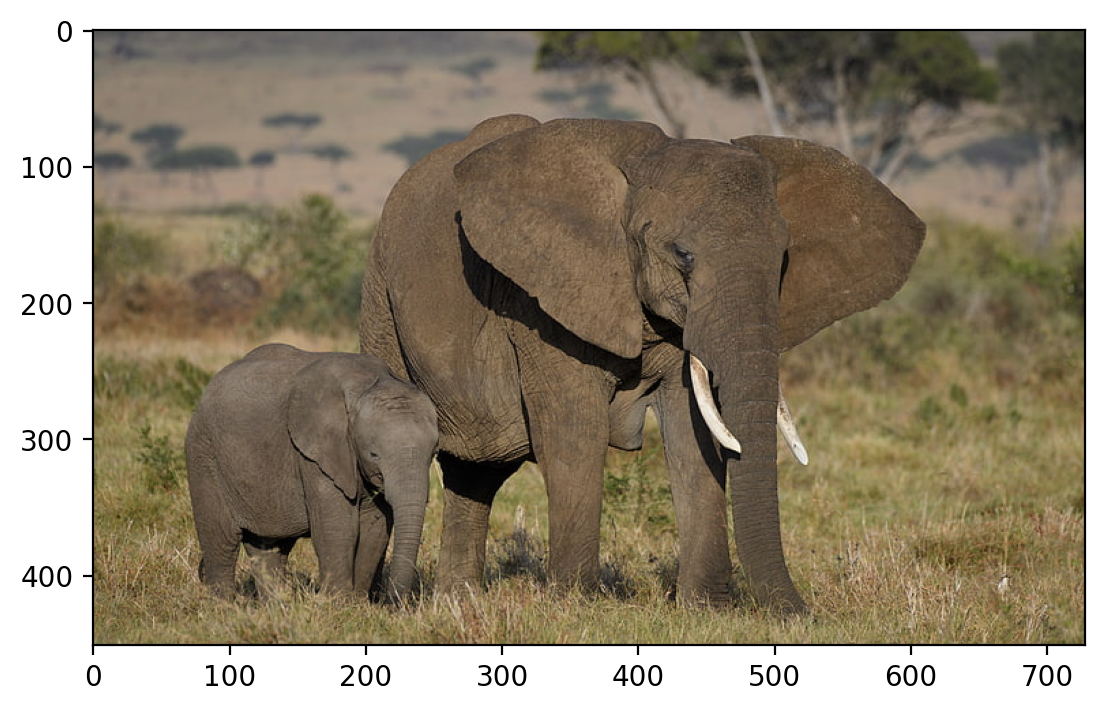

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

Scaling the image

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled.shape

torch.Size([3, 451, 728])

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_scaled = img_scaled.to(device)

In [8]:
img_scaled

tensor([[[0.3412, 0.3333, 0.3216,  ..., 0.2667, 0.2784, 0.2863],
         [0.3451, 0.3373, 0.3255,  ..., 0.2627, 0.2706, 0.2784],
         [0.3569, 0.3490, 0.3373,  ..., 0.2549, 0.2627, 0.2706],
         ...,
         [0.4863, 0.6039, 0.5373,  ..., 0.4235, 0.5137, 0.5529],
         [0.4980, 0.5804, 0.5137,  ..., 0.4314, 0.5216, 0.5294],
         [0.5098, 0.5490, 0.4941,  ..., 0.4353, 0.5373, 0.4941]],

        [[0.3490, 0.3412, 0.3294,  ..., 0.2745, 0.2863, 0.2941],
         [0.3529, 0.3451, 0.3333,  ..., 0.2706, 0.2784, 0.2863],
         [0.3569, 0.3490, 0.3373,  ..., 0.2627, 0.2706, 0.2784],
         ...,
         [0.4549, 0.5725, 0.5059,  ..., 0.3765, 0.4627, 0.5020],
         [0.4667, 0.5490, 0.4824,  ..., 0.3843, 0.4706, 0.4784],
         [0.4784, 0.5176, 0.4627,  ..., 0.3882, 0.4863, 0.4431]],

        [[0.3451, 0.3373, 0.3255,  ..., 0.2196, 0.2353, 0.2431],
         [0.3490, 0.3412, 0.3294,  ..., 0.2157, 0.2275, 0.2353],
         [0.3569, 0.3490, 0.3373,  ..., 0.2078, 0.2196, 0.

Cropping the image

torch.Size([3, 200, 200])


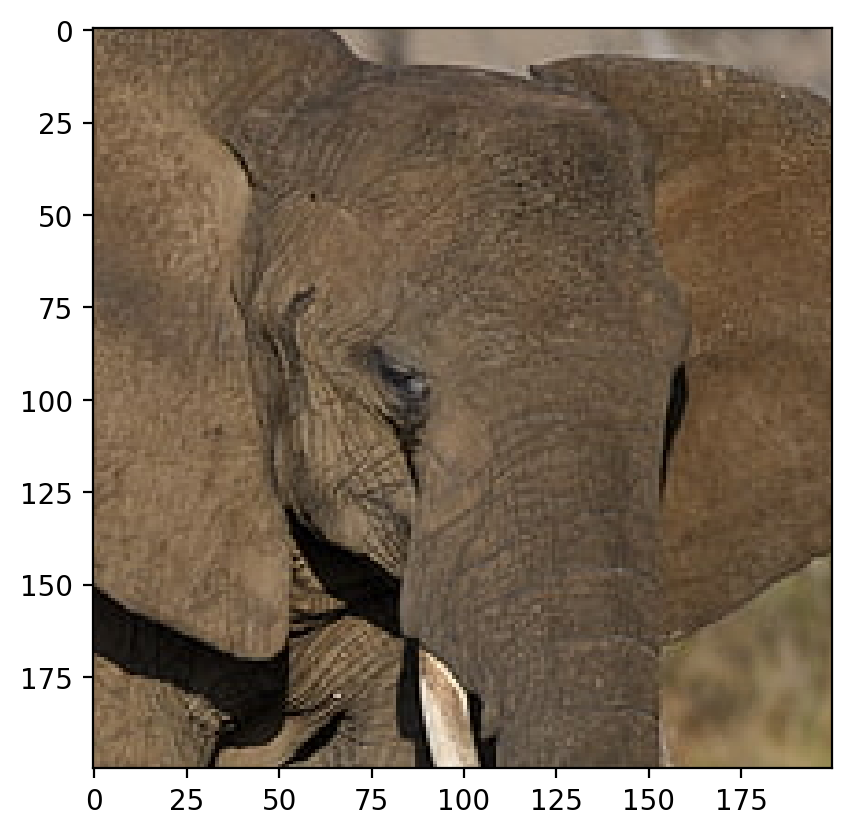

In [46]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 70, 350, 200, 200)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
crop = crop.to(device)

**Getting dimensions of the image tensor**

In [47]:
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 200 200


**Defining create coordinate map function**

In [16]:
def create_coordinate_map(img):
    
    num_channels, height, width = img.shape                 #extracting number of channels, height and width of the img
    
    #creating a 2D grid of (x,y) coordinates (h, w)
   
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    
    #flatening and combining the coordinates 
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
    X = torch.stack([h_coords, w_coords], dim=1).float()

    #move X to GPU if available for faster computations
    X = X.to(device)

    #reshaping the image
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [48]:
num_channels, height, width = crop.shape
num_channels, height, width 

(3, 200, 200)

In [49]:
image_X, image_Y = create_coordinate_map(crop)
image_X.shape, image_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [50]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(image_X.cpu())

#scaling the X coordinates
image_X_scaled = scaler_X.transform(image_X.cpu())

#moving the scaled X coordinates to the GPU
image_X_scaled = torch.tensor(image_X_scaled).to(device)

#setting to dtype float32
image_X_scaled = image_X_scaled.float()

In [20]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [51]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [22]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [52]:
train(net, 0.01, image_X_scaled, image_Y, 1000)

Epoch 0 loss: 0.543304
Epoch 100 loss: 0.020003
Epoch 200 loss: 0.010605
Epoch 300 loss: 0.010591
Epoch 400 loss: 0.010591
Epoch 500 loss: 0.010591
Epoch 600 loss: 0.010591
Epoch 700 loss: 0.010591
Epoch 800 loss: 0.010591
Epoch 900 loss: 0.010591


0.010590827092528343

In [24]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [25]:
#creating RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [57]:
X_rff = create_rff_features(image_X_scaled, 15000, 0.008)

In [58]:
X_rff.shape

torch.Size([40000, 15000])

In [59]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, image_Y, 1000)

Epoch 0 loss: 0.134122
Epoch 100 loss: 0.004224
Epoch 200 loss: 0.001940
Epoch 300 loss: 0.001464
Epoch 400 loss: 0.001230
Epoch 500 loss: 0.001101
Epoch 600 loss: 0.001024
Epoch 700 loss: 0.000976
Epoch 800 loss: 0.000947
Epoch 900 loss: 0.000927


0.0009146715747192502

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


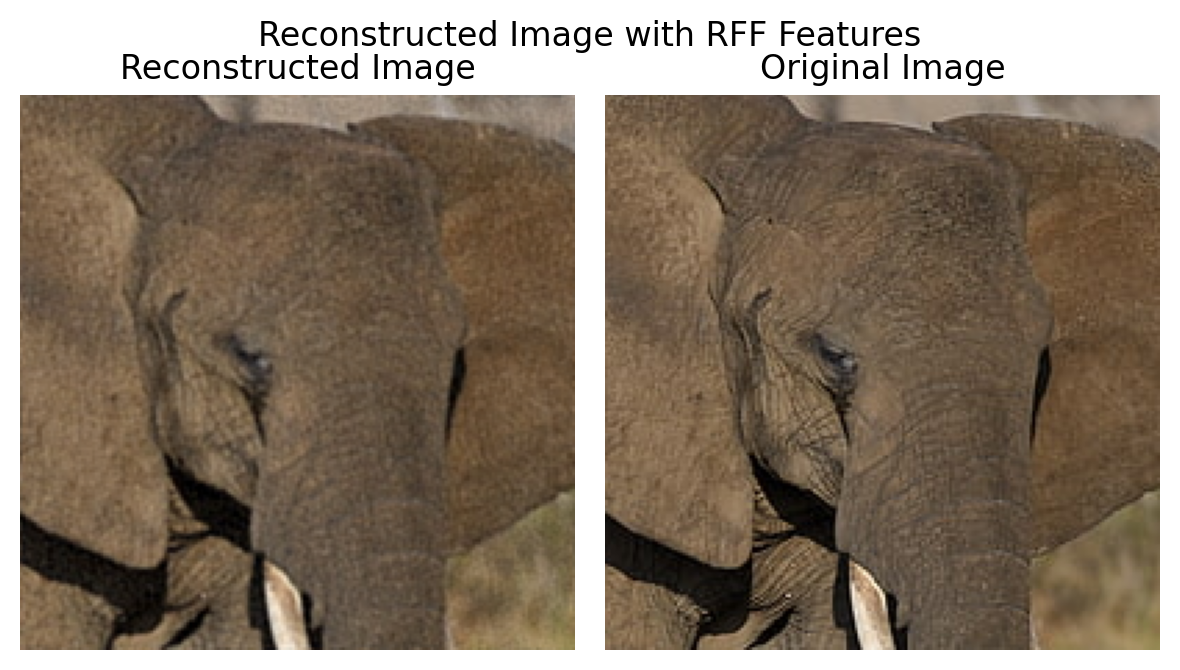

In [60]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

**Calculating RMSE and PSNR**

In [72]:
num_channels, height, width = crop.shape
net.eval()
with torch.no_grad():
    outputs = net(X_rff)
    outputs = outputs.reshape(height, width, num_channels)
print(rearrange(outputs, 'h w c -> c h w').shape)
print(crop.shape)

torch.Size([3, 200, 200])
torch.Size([3, 200, 200])


In [70]:
def cal_rmse(original_image, reconstructed_image):
    original_image = original_image.cpu().numpy().astype(np.float32)
    reconstructed_image = reconstructed_image.cpu().numpy().astype(np.float32)

    mse = np.mean((original_image-reconstructed_image)**2)
    rmse = np.sqrt(mse)
    return rmse

def cal_psnr(original_img, reconstructed_img):
    rmse = cal_rmse(original_img, reconstructed_img)
    psnr = 20 * np.log(255.0/rmse)
    return psnr

In [76]:
rmse = cal_rmse(crop*256, rearrange(outputs, 'h w c -> c h w')*256)
psnr = cal_psnr(crop*256, rearrange(outputs, 'h w c -> c h w')*256)
print(f"RMSE = {rmse}")
print(f"PSNR = {psnr}")

RMSE = 7.741901874542236
PSNR = 69.8923233503193
